# Classifying CT Scans with Pulmonary Embolisms

## Background

A pulmonary embolism (PE) is caused by an artery blockage in the lung. PEs are time consuming to confirm and consequently are prone to overdiagnosis. They are time consuming to confirm because they evey CT pulmonary angiography (CTPA) consists hundreds of images and every image has a chance of a PE being present.

Machine learning could be the solution. In this notebook we are going train a Convolutional Neural Network to accurately identify scans with PEs.

## Libraries and functions

In [228]:
#import necessary libraries and set the random seed for reproducibility
import numpy as np
import pandas as pd
import seaborn as sns
from keras import models
from keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation, rc
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score
np.random.seed(33)
import tensorflow as tf
import PIL
import glob
import os
import re
import pickle
from PIL import Image
from IPython.display import clear_output, display
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#function to display testing scores of a cnn
def nn_scores(actual, preds):
    rounded_preds = np.around(preds)
    acc = round(accuracy_score(actual, rounded_preds), 3)
    recall = round(recall_score(actual, rounded_preds), 3)
    precision = round(precision_score(actual, rounded_preds), 3)
    f1 = round(f1_score(actual, rounded_preds), 3)
    cm = confusion_matrix(actual, rounded_preds)
    
    #display testing scores
    print('             Testing Scores')
    print('           ' + '-'*19)
    print(f'          | Accuracy  | {acc:.3f} |')
    print(f'          | Recall    | {recall:.3f} |')
    print(f'          | Precision | {precision:.3f} |')
    print(f'          | F1        | {f1:.3f} |')
    print('           ' + '-'*19)

    #plot confusion matrix
    ax = plt.subplot()
    sns.heatmap(cm, fmt='.4g', annot=True, ax = ax, cmap ='Blues'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['No PE', 'PE Present']); ax.yaxis.set_ticklabels(['No PE', 'PE Present']);
    
    return [acc, recall, precision, f1, cm]

## Reading in the data

In [34]:
df = pd.read_csv('train.csv')

This dataframe contains all of the image ids and different information about about each image. For example, if a pulmonary embolism is present in the image.

In [21]:
df.shape

(1790594, 17)

There are almost 1.8 million images with 17 different features

In [3]:
df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


3 of the features are related to identifying the picture.

In [26]:
df['pe_present_on_image'].value_counts(normalize = True) * 100

0    94.608493
1     5.391507
Name: pe_present_on_image, dtype: float64

There is a high class imbalance. ~95% of images do not have a pulmonary embolism present.

### Organize Images

The files for the downloaded images are nested in layers of folders, so to make it easier to handle the images we moved the images into new folders. We used two folders one for images that have PE presents and a folder for those that don't. Additionally, for the sake of modeling time the images were downsampled to include 36k images from each class. The code for this isn't listed here due to brevity. (Go to very bottom for code)

---

In [100]:
scans = glob.glob('train-jpegs/*/*')
print('Total number of scans: ', len(scans))

Total number of scans:  7279


In [231]:
def animate(scan):
    fragments = glob.glob(scan + '/*')
    ims = []
    for f in fragments:
        print(f)
        break
        im = PIL.Image.open(f)
        im_data = im.getdata()
        ims.append(im_data)
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    imgplot = plt.imshow(ims[0], animated = True)

    def animate_func(i):
        imgplot.set_array(ims[i])
        return [imgplot]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

## Baseline Model

This model is a dummy classifier that only predict the majority class.

In [55]:
y = df['pe_present_on_image'] #target
x = np.zeros(len(y)) #dummy data

In [56]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x, y)

DummyClassifier(strategy='most_frequent')

In [57]:
dummy_preds = dummy_clf.predict(x)

             Testing Scores
           -------------------
          | Accuracy  | 0.946 |
          | Recall    | 0.000 |
          | Precision | 0.000 |
          | F1        | 0.000 |
           -------------------


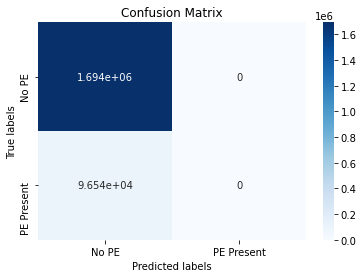

In [59]:
dummy_scores = nn_scores(y, dummy_preds)

As you can see from the scores and confusion matrix above. The accuracy is really high when only predicting on the majority class. Therefore, we sampled the from each class evenly to address the issue of class imbalance.

## Generic Model

First lets consolidate our images and the classes they belong to. Also, we will start off with a image batch size of 1000 to reduce the learning rate while we explore what parameters are important.

In [241]:
root = "data/"
data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        root, 
        target_size=(256, 256), 
        batch_size = 1000, 
        seed = 33)

Found 72527 images belonging to 2 classes.


As you can see there are two classes, ct scans where PE is present and scans where PE isn't present

---

Split our data into its images and classes.

In [242]:
images, labels = next(data_all)

Vizualize the first few images

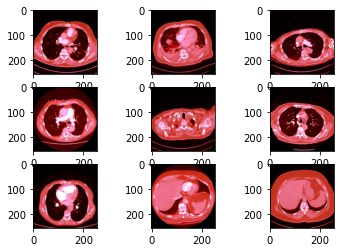

In [47]:
#visualize images
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(images[i])
plt.show()

Each image is a different ct scan. How you interpret the image is that you are looking at a person from the bottom of their feet. The top of the image is by their chin and the bottom is by their back. Black is air and contrast is used to vizualize blood flow.

---

Reshape labels, in order to perfrom train test split

In [243]:
labels = np.reshape(labels[:,0], (1000,1))

Split data into train and validation set

In [244]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.20, random_state=33)

Testing set

In [245]:
X_test, y_test = next(data_all)
y_test = np.reshape(y_test[:,0], (1000,1))

Model

In [100]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[tf.keras.metrics.Recall()])

In [101]:
cnn.fit(X_train,
        y_train,
        epochs=5,
        batch_size=50,
        validation_data=(X_val, y_val),
        verbose = 1,
        workers = 7)

Epoch 1/5
16/16 [==============================] - 185s 12s/step - loss: 0.6473 - recall_9: 0.7512 - val_loss: 0.6285 - val_recall_9: 0.3137
Epoch 2/5
16/16 [==============================] - 184s 11s/step - loss: 0.5448 - recall_9: 0.7122 - val_loss: 0.6250 - val_recall_9: 0.3824
Epoch 3/5
16/16 [==============================] - 181s 11s/step - loss: 0.4947 - recall_9: 0.7244 - val_loss: 0.5236 - val_recall_9: 0.6569
Epoch 4/5
16/16 [==============================] - 181s 11s/step - loss: 0.4372 - recall_9: 0.7780 - val_loss: 0.5028 - val_recall_9: 0.6765
Epoch 5/5
16/16 [==============================] - 179s 11s/step - loss: 0.4225 - recall_9: 0.7683 - val_loss: 0.5428 - val_recall_9: 0.6078


In [104]:
cnn.evaluate(X_test, y_test)

32/32 [==============================] - 62s 2s/step - loss: 0.4820 - recall_9: 0.6245


[0.4820467531681061, 0.6244897842407227]

In [105]:
#predictions
cnn_preds = cnn.predict(X_test)

             Testing Scores
           -------------------
          | Accuracy  | 0.797 |
          | Recall    | 0.624 |
          | Precision | 0.942 |
          | F1        | 0.751 |
           -------------------


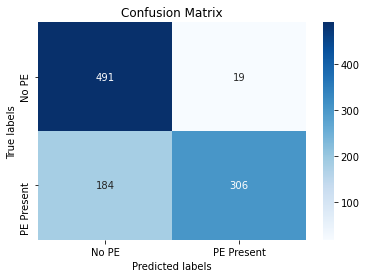

In [169]:
#testing score
cnn_scores = nn_scores(y_test, cnn_preds)

The first model performed better than random guessing in everything but accuracy. It is fair model, however, for a medical application we need to decrease the false negatives. A recall of 62% isn't great. Consequently, we need to experiment with different parameters and find a better model for our application. All in all though this was a decent start.

In [199]:
# save model
cnn.save('cnn_vanilla')
cnn.save_weights('cnn_vanilla_weights')

INFO:tensorflow:Assets written to: cnn_vanilla/assets


## Adam Optimizer

For this model we are keeping everything the same but changing the optimizer to Adam, which is the arguably the industry standard right now.

In [80]:
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(128, activation='relu'))
cnn2.add(layers.Dense(1, activation='sigmoid'))

cnn2.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=[tf.keras.metrics.Recall()])

In [81]:
cnn2.fit(X_train,
        y_train,
        epochs=5,
        batch_size=50,
        validation_data=(X_val, y_val),
        verbose = 1,
        workers = 7)

Epoch 1/5
16/16 [==============================] - 177s 11s/step - loss: 3.2357 - recall_8: 0.6512 - val_loss: 0.5646 - val_recall_8: 0.6471
Epoch 2/5
16/16 [==============================] - 173s 11s/step - loss: 0.4201 - recall_8: 0.7780 - val_loss: 0.4730 - val_recall_8: 0.6667
Epoch 3/5
16/16 [==============================] - 172s 11s/step - loss: 0.3126 - recall_8: 0.8561 - val_loss: 0.4392 - val_recall_8: 0.8824
Epoch 4/5
16/16 [==============================] - 172s 11s/step - loss: 0.2427 - recall_8: 0.9000 - val_loss: 0.4510 - val_recall_8: 0.7255
Epoch 5/5
16/16 [==============================] - 172s 11s/step - loss: 0.1707 - recall_8: 0.9195 - val_loss: 0.5225 - val_recall_8: 0.7843


In [82]:
cnn2.evaluate(X_test, y_test)

32/32 [==============================] - 63s 2s/step - loss: 0.3980 - recall_8: 0.7755


[0.398004949092865, 0.7755101919174194]

In [83]:
#predictions
cnn2_preds = cnn2.predict(X_test)

             Testing Scores
           -------------------
          | Accuracy  | 0.848 |
          | Recall    | 0.776 |
          | Precision | 0.900 |
          | F1        | 0.833 |
           -------------------


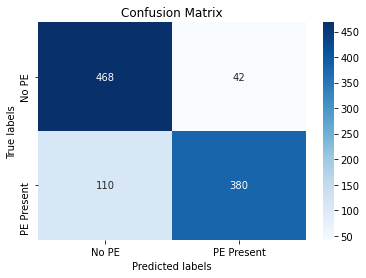

In [170]:
#testing scores
cnn2_scores = nn_scores(y_test, cnn2_preds)

This performed better than our generic model. The recall jumped to 78% percent from 62%. This is a significant improvment and we a trending in the right direction. Also, all of our other testing scores increased as well.

In [203]:
# save model
cnn2.save('cnn2')
cnn2.save_weights('cnn2_weights')

INFO:tensorflow:Assets written to: cnn2/assets


## 3 conv layers and striding of 2

For this model we are going to increase the convolutional layers and reduce memory requirements between the layers
by using a stride of 2 in both directions for max pooling after each convolutional layer.

In [171]:
cnn3 = models.Sequential()
cnn3.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn3.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn3.add(layers.Conv2D(512, (3, 3), activation='relu'))
cnn3.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn3.add(layers.Conv2D(1024, (3, 3), activation='relu'))
cnn3.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(128, activation='relu'))
cnn3.add(layers.Dense(1, activation='sigmoid'))

cnn3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=[tf.keras.metrics.Recall()])

In [172]:
cnn3.fit(X_train,
        y_train,
        epochs=5,
        batch_size=50,
        validation_data=(X_val, y_val),
        verbose = 1,
        workers = 7)

Epoch 1/5
16/16 [==============================] - 516s 32s/step - loss: 4.1569 - recall_10: 0.7683 - val_loss: 0.6733 - val_recall_10: 1.0000
Epoch 2/5
16/16 [==============================] - 500s 31s/step - loss: 0.5980 - recall_10: 0.7634 - val_loss: 0.5885 - val_recall_10: 0.6275
Epoch 3/5
16/16 [==============================] - 500s 31s/step - loss: 0.4708 - recall_10: 0.7488 - val_loss: 0.5747 - val_recall_10: 0.7843
Epoch 4/5
16/16 [==============================] - 513s 32s/step - loss: 0.4135 - recall_10: 0.8098 - val_loss: 0.5266 - val_recall_10: 0.6863
Epoch 5/5
16/16 [==============================] - 512s 32s/step - loss: 0.3645 - recall_10: 0.8073 - val_loss: 0.4568 - val_recall_10: 0.7941


In [173]:
cnn3.evaluate(X_test, y_test)

32/32 [==============================] - 198s 6s/step - loss: 0.3772 - recall_10: 0.8020


[0.37723737955093384, 0.8020408153533936]

In [174]:
#predictions
cnn3_preds = cnn3.predict(X_test)

             Testing Scores
           -------------------
          | Accuracy  | 0.842 |
          | Recall    | 0.802 |
          | Precision | 0.866 |
          | F1        | 0.833 |
           -------------------


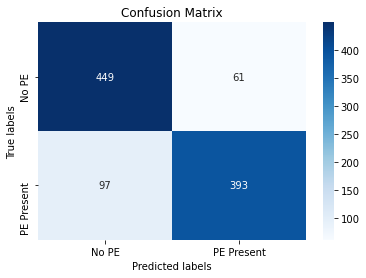

In [193]:
#testing scores
cnn3_scores = nn_scores(y_test, cnn3_preds)

By adding another layer and using a stride length of two, recall was improved. However, the improvement was only marginal. Accuracy and F1 stayed approximately the same. Precision decrease as the expense of an increase in recall which is normal. In conclusion, this model didn't add much for an increase in complexity. Let's try keeping the stride length the same and going back to 2 convolutional layers.

In [204]:
# save model
cnn3.save('cnn3')
cnn3.save_weights('cnn3_weights')

INFO:tensorflow:Assets written to: cnn3/assets


## 2 conv layers and stride of 2

This model decreases the convolutional layers by one and keeps eveything else the same from the last model

In [176]:
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(512, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn4.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn4.add(layers.Conv2D(512, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn4.add(layers.Flatten())
cnn4.add(layers.Dense(128, activation='relu'))
cnn4.add(layers.Dense(1, activation='sigmoid'))

cnn4.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=[tf.keras.metrics.Recall()])

In [177]:
cnn4.fit(X_train,
        y_train,
        epochs=5,
        batch_size=50,
        validation_data=(X_val, y_val),
        verbose = 1,
        workers = 7)

Epoch 1/5
16/16 [==============================] - 624s 39s/step - loss: 8.7738 - recall_11: 0.5683 - val_loss: 0.5138 - val_recall_11: 0.7255
Epoch 2/5
16/16 [==============================] - 605s 38s/step - loss: 0.4788 - recall_11: 0.8244 - val_loss: 0.4882 - val_recall_11: 0.5980
Epoch 3/5
16/16 [==============================] - 609s 38s/step - loss: 0.3352 - recall_11: 0.8561 - val_loss: 0.4588 - val_recall_11: 0.8431
Epoch 4/5
16/16 [==============================] - 605s 38s/step - loss: 0.2198 - recall_11: 0.9195 - val_loss: 0.4345 - val_recall_11: 0.8431
Epoch 5/5
16/16 [==============================] - 609s 38s/step - loss: 0.1067 - recall_11: 0.9561 - val_loss: 0.4915 - val_recall_11: 0.8431


In [179]:
cnn4.evaluate(X_test, y_test)

32/32 [==============================] - 229s 7s/step - loss: 0.3464 - recall_11: 0.8306


[0.3463621735572815, 0.8306122422218323]

In [180]:
#predicitions
cnn4_preds = cnn4.predict(X_test)

             Testing Scores
           -------------------
          | Accuracy  | 0.862 |
          | Recall    | 0.831 |
          | Precision | 0.881 |
          | F1        | 0.855 |
           -------------------


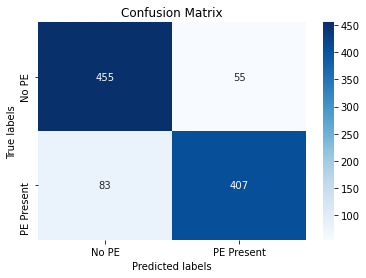

In [181]:
#testing scores
cnn4_scores = nn_scores(y_test, cnn4_preds)

All of our testing metrics improved in this model. The one thing that is slightly concerning is that overfitting is starting to happen. This can be addressed by increasing our testing size. It is interesting that reducing layers leads to overfitting. I believe this might be becuase detecting pulmonary embolisms is a hard task that relies on spotting minute differences in blood flow. Consequently, less neurons reduces a models success with unseen data.

In [205]:
# save model
cnn4.save('cnn4')
cnn4.save_weights('cnn4_weights')

INFO:tensorflow:Assets written to: cnn4/assets


## Increased neurons in penultimate layer

In this model the neurons in the layer before the output are increased to 256 from 128.

In [182]:
cnn5 = models.Sequential()
cnn5.add(layers.Conv2D(512, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn5.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn5.add(layers.Conv2D(512, (3, 3), activation='relu'))
cnn5.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn5.add(layers.Flatten())
cnn5.add(layers.Dense(256, activation='relu'))
cnn5.add(layers.Dense(1, activation='sigmoid'))

cnn5.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=[tf.keras.metrics.Recall()])

In [183]:
cnn5.fit(X_train,
        y_train,
        epochs=5,
        batch_size=50,
        validation_data=(X_val, y_val),
        verbose = 1,
        workers = 7)

Epoch 1/5
16/16 [==============================] - 685s 43s/step - loss: 6.5523 - recall_12: 0.6683 - val_loss: 0.4464 - val_recall_12: 0.8333
Epoch 2/5
16/16 [==============================] - 659s 41s/step - loss: 0.4249 - recall_12: 0.7976 - val_loss: 0.4273 - val_recall_12: 0.8137
Epoch 3/5
16/16 [==============================] - 622s 39s/step - loss: 0.3407 - recall_12: 0.8244 - val_loss: 0.4164 - val_recall_12: 0.7059
Epoch 4/5
16/16 [==============================] - 629s 39s/step - loss: 0.2562 - recall_12: 0.8732 - val_loss: 0.4269 - val_recall_12: 0.8725
Epoch 5/5
16/16 [==============================] - 628s 39s/step - loss: 0.1308 - recall_12: 0.9390 - val_loss: 0.6072 - val_recall_12: 0.9412


In [184]:
cnn5.evaluate(X_test, y_test)

32/32 [==============================] - 224s 7s/step - loss: 0.4603 - recall_12: 0.9163


[0.46028879284858704, 0.9163265228271484]

In [186]:
#predicitions
cnn5_preds = cnn5.predict(X_test)

             Testing Scores
           -------------------
          | Accuracy  | 0.818 |
          | Recall    | 0.916 |
          | Precision | 0.761 |
          | F1        | 0.831 |
           -------------------


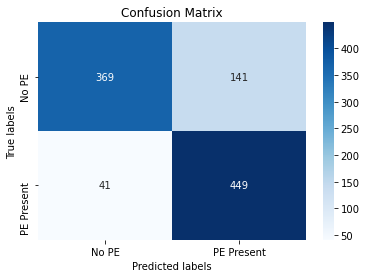

In [187]:
#testing scores
cnn5_scores = nn_scores(y_test, cnn5_preds)

This model has performed the best in terms of recall. Additionally, it is not overfitting which is great. The main critique of this model is it's accuracy score. Ideally, it would be much higher. Training with a larger dataset should help this.

In [206]:
# save model
cnn5.save('cnn5')
cnn5.save_weights('cnn5_weights')

INFO:tensorflow:Assets written to: cnn5/assets


## Decreased neurons in penultimate layer

This time let's go the other direction with the neurons in the layer before the output layer. We decreased the neurons from 128 to 64.

In [188]:
cnn6 = models.Sequential()
cnn6.add(layers.Conv2D(512, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn6.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn6.add(layers.Conv2D(512, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn6.add(layers.Flatten())
cnn6.add(layers.Dense(64, activation='relu'))
cnn6.add(layers.Dense(1, activation='sigmoid'))

cnn6.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=[tf.keras.metrics.Recall()])

In [189]:
cnn6.fit(X_train,
        y_train,
        epochs=5,
        batch_size=50,
        validation_data=(X_val, y_val),
        verbose = 1,
        workers = 7)

Epoch 1/5
16/16 [==============================] - 677s 42s/step - loss: 3.3710 - recall_13: 0.8732 - val_loss: 0.6276 - val_recall_13: 0.9412
Epoch 2/5
16/16 [==============================] - 651s 41s/step - loss: 0.4394 - recall_13: 0.8341 - val_loss: 0.5182 - val_recall_13: 0.5980
Epoch 3/5
16/16 [==============================] - 625s 39s/step - loss: 0.3212 - recall_13: 0.8390 - val_loss: 0.4386 - val_recall_13: 0.8039
Epoch 4/5
16/16 [==============================] - 640s 40s/step - loss: 0.2017 - recall_13: 0.9122 - val_loss: 0.4714 - val_recall_13: 0.7745
Epoch 5/5
16/16 [==============================] - 687s 43s/step - loss: 0.1008 - recall_13: 0.9585 - val_loss: 0.5724 - val_recall_13: 0.7059


In [ ]:
cnn6.evaluate(X_test, y_test)

In [191]:
#predictions
cnn6_preds = cnn6.predict(X_test)

             Testing Scores
           -------------------
          | Accuracy  | 0.848 |
          | Recall    | 0.792 |
          | Precision | 0.886 |
          | F1        | 0.836 |
           -------------------


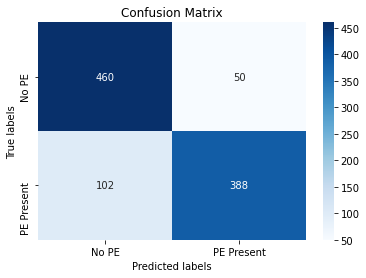

In [192]:
#testing scores
cnn6_scores = nn_scores(y_test, cnn6_preds)

Again, there is an issue of overfitting when we decrease the amount of neurons. This confirms that we need more neurons to be able to better classifying pulmonary embolisms with unseen data.

In [207]:
# save model
cnn6.save('cnn6')
cnn6.save_weights('cnn6_weights')

INFO:tensorflow:Assets written to: cnn6/assets


## Reducing neurons in each layer by half

This model was more of an educated guess. I remembered reading somewhere about reducing each layer's nuerons by a factor of 2 each time. So I did that and added a third convolutional layer. Additionally, I didn't use a stride length for the last max pooling layer.

In [246]:
cnn7 = models.Sequential()
cnn7.add(layers.Conv2D(512, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn7.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn7.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn7.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D(pool_size = (2, 2)))
cnn7.add(layers.Flatten())
cnn7.add(layers.Dense(256, activation='relu'))
cnn7.add(layers.Dense(1, activation='sigmoid'))

cnn7.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc', tf.keras.metrics.Recall()])

In [248]:
cnn7.fit(X_train,
        y_train,
        epochs=5,
        batch_size=50,
        validation_data=(X_val, y_val),
        verbose = 1,
        workers = 7)

Epoch 1/5
16/16 [==============================] - 403s 25s/step - loss: 0.6018 - acc: 0.6913 - recall_3: 0.7171 - val_loss: 0.5331 - val_acc: 0.7350 - val_recall_3: 0.6078
Epoch 2/5
16/16 [==============================] - 377s 24s/step - loss: 0.4320 - acc: 0.8075 - recall_3: 0.7463 - val_loss: 0.4554 - val_acc: 0.7450 - val_recall_3: 0.8039
Epoch 3/5
16/16 [==============================] - 366s 23s/step - loss: 0.3678 - acc: 0.8500 - recall_3: 0.8512 - val_loss: 0.4625 - val_acc: 0.7850 - val_recall_3: 0.9020
Epoch 4/5
16/16 [==============================] - 370s 23s/step - loss: 0.3001 - acc: 0.8763 - recall_3: 0.8537 - val_loss: 0.4387 - val_acc: 0.8000 - val_recall_3: 0.8529
Epoch 5/5
16/16 [==============================] - 388s 24s/step - loss: 0.2391 - acc: 0.9062 - recall_3: 0.8927 - val_loss: 0.4339 - val_acc: 0.8300 - val_recall_3: 0.9020


In [249]:
cnn7_preds = cnn7.predict(X_test)

             Testing Scores
           -------------------
          | Accuracy  | 0.857 |
          | Recall    | 0.853 |
          | Precision | 0.855 |
          | F1        | 0.854 |
           -------------------


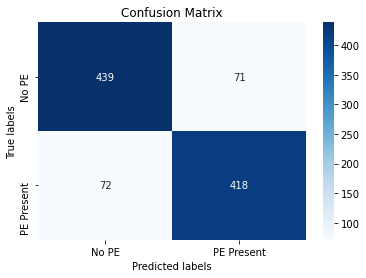

In [250]:
cnn7_scores = nn_scores(y_test, cnn7_preds)

Being less systematic for the apporach for this model paid of. It ended up being the best model overall. I think it's the best overall, becuase it's accuracy as well as recall are high where for the other models it's either or. This will be the model we try to optimize with more training images and more epochs.

In [251]:
# save model
cnn7.save('cnn7')
cnn7.save_weights('cnn7_weights')

INFO:tensorflow:Assets written to: cnn7/assets


## Final Models

Now that we have a model with features that perform the best, we will increase the size of our test, validation, and training sets to 4800, 1200 and 5000 respectively. Increasing the amount of images trained on will increase performance. (Note: These numbers are selected based on our current computer's processing limitations.)

In [4]:
root = "data/"
data_all2 = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        root, 
        target_size=(256, 256), 
        batch_size = 5000, 
        seed = 33)

Found 72527 images belonging to 2 classes.


Split our data into its images and classes.

In [5]:
images2, labels2 = next(data_all2)

Reshape labels, in order to perfrom train test split

In [6]:
labels2 = np.reshape(labels2[:,0], (5000,1))

Train test split the validation and training set as well as get our test set.

In [7]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(images2, labels2, test_size=0.20, random_state=33)

X_test2, y_test2 = next(data_all2)

y_test2 = np.reshape(y_test2[:,0], (5000,1))

### Increased training and validation set size (epochs = 5)

In [8]:
cnn8 = models.Sequential()
cnn8.add(layers.Conv2D(512, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn8.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn8.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn8.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn8.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn8.add(layers.MaxPooling2D(pool_size = (2, 2)))
cnn8.add(layers.Flatten())
cnn8.add(layers.Dense(256, activation='relu'))
cnn8.add(layers.Dense(1, activation='sigmoid'))

cnn8.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc', tf.keras.metrics.Recall()])

In [9]:
cnn8.fit(X_train2,
        y_train2,
        epochs=5,
        batch_size=50,
        validation_data=(X_val2, y_val2),
        verbose = 1,
        workers = 7)

Epoch 1/5
80/80 [==============================] - 1992s 25s/step - loss: 0.5407 - acc: 0.7623 - recall: 0.7571 - val_loss: 0.3415 - val_acc: 0.8580 - val_recall: 0.9000
Epoch 2/5
80/80 [==============================] - 1939s 24s/step - loss: 0.3156 - acc: 0.8695 - recall: 0.8563 - val_loss: 0.2892 - val_acc: 0.8830 - val_recall: 0.8549
Epoch 3/5
80/80 [==============================] - 1906s 24s/step - loss: 0.2693 - acc: 0.8970 - recall: 0.8833 - val_loss: 0.2645 - val_acc: 0.8950 - val_recall: 0.8392
Epoch 4/5
80/80 [==============================] - 1866s 23s/step - loss: 0.1964 - acc: 0.9268 - recall: 0.9134 - val_loss: 0.2782 - val_acc: 0.8960 - val_recall: 0.9471
Epoch 5/5
80/80 [==============================] - 1855s 23s/step - loss: 0.1447 - acc: 0.9465 - recall: 0.9394 - val_loss: 0.2123 - val_acc: 0.9200 - val_recall: 0.9000


In [10]:
#predictions
cnn8_preds = cnn8.predict(X_test2)

             Testing Scores
           -------------------
          | Accuracy  | 0.914 |
          | Recall    | 0.896 |
          | Precision | 0.931 |
          | F1        | 0.913 |
           -------------------


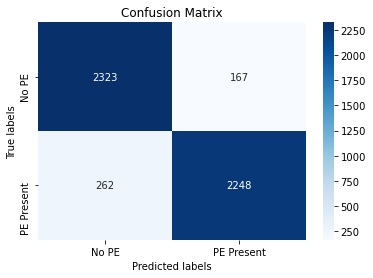

In [16]:
#testing scores
cnn8_scores = nn_scores(y_test2, cnn8_preds)

This definitely helped our model. You can see how all of the testing scores increased from the model trained on less images. Let's see if increasing the number of epochs helps.

In [238]:
# save model
cnn8.save('cnn8')
cnn8.save_weights('cnn8_weights')

INFO:tensorflow:Assets written to: cnn8/assets


### Increased training and validation set size (epochs = 15)

Increased epochs to 15

In [11]:
cnn9 = models.Sequential()
cnn9.add(layers.Conv2D(512, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn9.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn9.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn9.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn9.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn9.add(layers.MaxPooling2D(pool_size = (2, 2)))
cnn9.add(layers.Flatten())
cnn9.add(layers.Dense(256, activation='relu'))
cnn9.add(layers.Dense(1, activation='sigmoid'))

cnn9.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc', tf.keras.metrics.Recall()])

In [12]:
cnn9.fit(X_train2,
        y_train2,
        epochs=15,
        batch_size=50,
        validation_data=(X_val2, y_val2),
        verbose = 1,
        workers = 7)

Epoch 1/15
80/80 [==============================] - 1945s 24s/step - loss: 0.7189 - acc: 0.7605 - recall_1: 0.7321 - val_loss: 0.3397 - val_acc: 0.8660 - val_recall_1: 0.8627
Epoch 2/15
80/80 [==============================] - 1896s 24s/step - loss: 0.3151 - acc: 0.8770 - recall_1: 0.8708 - val_loss: 0.3462 - val_acc: 0.8810 - val_recall_1: 0.8137
Epoch 3/15
80/80 [==============================] - 1898s 24s/step - loss: 0.2691 - acc: 0.9000 - recall_1: 0.8963 - val_loss: 0.2518 - val_acc: 0.8980 - val_recall_1: 0.8941
Epoch 4/15
80/80 [==============================] - 1884s 24s/step - loss: 0.2160 - acc: 0.9210 - recall_1: 0.9239 - val_loss: 0.2733 - val_acc: 0.8890 - val_recall_1: 0.8059
Epoch 5/15
80/80 [==============================] - 1887s 24s/step - loss: 0.1713 - acc: 0.9340 - recall_1: 0.9279 - val_loss: 0.2365 - val_acc: 0.9050 - val_recall_1: 0.9039
Epoch 6/15
80/80 [==============================] - 1867s 23s/step - loss: 0.0931 - acc: 0.9647 - recall_1: 0.9629 - val_loss

In [13]:
cnn9_preds = cnn9.predict(X_test2)

             Testing Scores
           -------------------
          | Accuracy  | 0.915 |
          | Recall    | 0.941 |
          | Precision | 0.896 |
          | F1        | 0.918 |
           -------------------


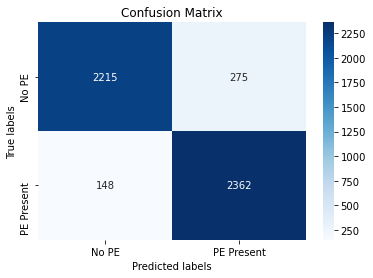

In [15]:
cnn9_scores = nn_scores(y_test2, cnn9_preds)

Again this helped improve the model. All testing scores went up besides precision which makes sense because increasing recall tends to reduce precision. You can see by the model training output 2 cells above that at epoch 10 the best scores were achieved. Consequently, 15 might be too much and overfitting is starting to occur. Let's try 10 epochs for then next model.

In [239]:
# save model
cnn9.save('cnn9')
cnn9.save_weights('cnn9_weights')

INFO:tensorflow:Assets written to: cnn9/assets


### Increased training and validation set size (epochs = 10)

Reduced epochs to 10

In [17]:
cnn10 = models.Sequential()
cnn10.add(layers.Conv2D(512, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn10.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn10.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn10.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
cnn10.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn10.add(layers.MaxPooling2D(pool_size = (2, 2)))
cnn10.add(layers.Flatten())
cnn10.add(layers.Dense(256, activation='relu'))
cnn10.add(layers.Dense(1, activation='sigmoid'))

cnn10.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc', tf.keras.metrics.Recall()])

In [18]:
cnn10.fit(X_train2,
        y_train2,
        epochs=10,
        batch_size=50,
        validation_data=(X_val2, y_val2),
        verbose = 1,
        workers = 7)

Epoch 1/10
80/80 [==============================] - 2119s 26s/step - loss: 0.6169 - acc: 0.7138 - recall_2: 0.6760 - val_loss: 0.3567 - val_acc: 0.8340 - val_recall_2: 0.8569
Epoch 2/10
80/80 [==============================] - 2017s 25s/step - loss: 0.3344 - acc: 0.8665 - recall_2: 0.8503 - val_loss: 0.3099 - val_acc: 0.8650 - val_recall_2: 0.7784
Epoch 3/10
80/80 [==============================] - 1888s 24s/step - loss: 0.2766 - acc: 0.8925 - recall_2: 0.8833 - val_loss: 0.2549 - val_acc: 0.9030 - val_recall_2: 0.9157
Epoch 4/10
80/80 [==============================] - 1864s 23s/step - loss: 0.2067 - acc: 0.9165 - recall_2: 0.9084 - val_loss: 0.2520 - val_acc: 0.9060 - val_recall_2: 0.8588
Epoch 5/10
80/80 [==============================] - 1862s 23s/step - loss: 0.1464 - acc: 0.9460 - recall_2: 0.9464 - val_loss: 0.2289 - val_acc: 0.9010 - val_recall_2: 0.8745
Epoch 6/10
80/80 [==============================] - 1853s 23s/step - loss: 0.1006 - acc: 0.9647 - recall_2: 0.9639 - val_loss

In [19]:
cnn10_preds = cnn10.predict(X_test2)

             Testing Scores
           -------------------
          | Accuracy  | 0.916 |
          | Recall    | 0.945 |
          | Precision | 0.893 |
          | F1        | 0.919 |
           -------------------


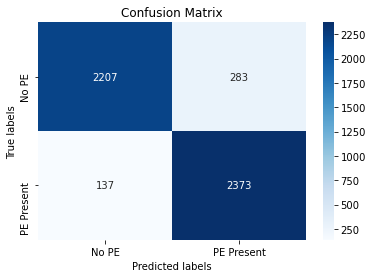

In [21]:
cnn10_score = nn_scores(y_test2, cnn10_preds)

Wohoo! This model produced the best results. Epochs decreased and every measure besides precision was improved. This we be the final model.

In [240]:
# save model
cnn10.save('cnn10')
cnn10.save_weights('cnn10_weights')

INFO:tensorflow:Assets written to: cnn10/assets


## Conclusion

Medical practitioners who utlize this model would reduce the time it takes to confirm a diagnosis of a PE. The model could be used to identify which images have a PE present and would give the practicioner a good starting place for what images to examine first to confirm the PE. This would help shorten the time it takes for treatment to start, and in turn prevent deaths.

## Appendix

In [35]:
# #Code to organize files
# root = "data/"
# train_files = []
# for path, subdirs, files in os.walk(root):
#     for name in files:
#         train_files.append(os.path.join(path, name)) 
        
# train_files = list(filter(lambda x: re.findall(r'\/([\w]*)\.jpg$', x) != [], train_files))
# x = dict(map(lambda x: (re.findall(r'\/([\w]*)\.jpg$', x)[0], x), train_files))
# filename_df = pd.DataFrame.from_dict(x, orient='index', columns=['filepath'])
# df_w_filepath = pd.merge(df, filename_df, left_on='SOPInstanceUID', right_index=True, how='left')

# train_img_no_pe = df_w_filepath.query('pe_present_on_image == 0')['filepath']
# train_img_pe_present = df_w_filepath.query('pe_present_on_image == 1')['filepath']

# task1 = train_img_no_pe.shape[0]
# task2 = train_img_pe_present.shape[0]
# for index, each in enumerate(train_img_no_pe):
#     new_path = each[-16:]
#     clear_output(wait = True)
#     !mv $each no_pe/$new_path
#     if index == 36000:
#         break
#     display(index/task1 * 100)
# for index, each in enumerate(train_img_pe_present):
#     new_path = each[-16:]
#     clear_output(wait = True)
#     !mv $each pe_present/$new_path
#     display(index/task2 * 100)
#     if index == 36000:
#         break